In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from os.path import exists, join
import os
import xarray as xr
import pandas as pd
from glob import glob
import sys
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LogNorm
from IPython.display import Image
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC, DistributedReliability
from hagelslag.evaluation.MetricPlotter import roc_curve, performance_diagram, attributes_diagram
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Input, Conv1D, Merge, concatenate
from keras.layers import Activation, Reshape, LeakyReLU, concatenate, Dropout, BatchNormalization, AlphaDropout
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras.models import load_model
from sklearn.utils import class_weight
from sklearn.svm import SVC
from deepsky.gan import rescale_multivariate_data, rescale_data
from scipy.stats import percentileofscore
from sklearn.cluster import KMeans
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "6"


# Data Loading
Load storm patch data from every file.

In [2]:
def load_storm_patch_data(data_path, variable_names):
    data_patches = []
    centers = []
    valid_dates = []
    data_files = sorted(glob(join(data_path, "*.nc")))
    for data_file in data_files:
        print(data_file)
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        if np.all(np.in1d(variable_names, all_vars)):
            centers.append(np.array([ds["longitude"][:, 32, 32], ds["latitude"][:, 32, 32]]).T)
            valid_dates.append(ds["valid_date"].values)
            for variable in variable_names:
                patch_arr.append(ds[variable][:, 16:-16, 16:-16].values)
            data_patches.append(np.stack(patch_arr, axis=-1))
        ds.close()
    center_arr = np.vstack(centers)
    valid_date_index = pd.DatetimeIndex(np.concatenate(valid_dates))
    data = np.vstack(data_patches)
    return data, center_arr, valid_date_index

In [7]:
def normalize_multivariate_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, :, i].mean(), data[:, :, :, i].std()]
        normed_data[:, :, :, i] = (data[:, :, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values


def unnormalize_multivariate_data(normed_data, scaling_values):
    """
    Return normalized data to original values by multiplying by standard deviation and adding the mean.

    Args:
        normed_data: 4-dimensional array of normalized values with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        data array
    """
    data = np.zeros(normed_data.shape, dtype=normed_data.dtype)
    for i in range(normed_data.shape[-1]):
        data[:, :, :, i] = normed_data[:, :, :, i] * scaling_values.loc[i, "std"] + scaling_values.loc[i, "mean"]
    return data


In [3]:
data = xr.open_dataset("/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_09.nc")

In [ ]:
plt.pcolormesh(data['dew_point_temperature_850_mb_prev'][482][16:-16, 16:-16])
plt.colorbar()

In [7]:
all_vars = list(data.variables.keys())
variable_names = ['composite_reflectivity_entire_atmosphere_current',
                  'precipitable_water_entire_atmosphere_(considered_as_a_single_layer)_current',
                  'geopotential_height_level_of_adiabatic_condensation_from_sfc_prev',
                  'convective_available_potential_energy_180-0_mb_above_ground_prev',
                  'vertical_u-component_shear_0-6000_m_above_ground_prev',
                  'vertical_v-component_shear_0-6000_m_above_ground_prev',
                  ]
np.all(np.in1d(variable_names, all_vars))

True

In [5]:
ua_vars = ['geopotential_height_500_mb_prev',
           'geopotential_height_700_mb_prev',
           'geopotential_height_850_mb_prev',
           'temperature_500_mb_prev',
             'temperature_700_mb_prev',
             'temperature_850_mb_prev',
             'dew_point_temperature_500_mb_prev',
            'dew_point_temperature_700_mb_prev',
             'dew_point_temperature_850_mb_prev',
             'u-component_of_wind_500_mb_prev',
             'u-component_of_wind_700_mb_prev',
             'u-component_of_wind_850_mb_prev',
             'v-component_of_wind_500_mb_prev',
             'v-component_of_wind_700_mb_prev',
             'v-component_of_wind_850_mb_prev']
ua_data, ua_centers, ua_dates = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", ua_vars)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc
/scr

In [28]:
unique_storm_dates = np.unique(ua_dates.date)
shuffled_storm_dates = np.random.permutation(unique_storm_dates)
split_point = int(0.7 * len(shuffled_storm_dates))
train_dates = np.sort(shuffled_storm_dates[:split_point])
test_dates = np.sort(shuffled_storm_dates[split_point:])
train_indices = np.where(np.in1d(ua_dates.date, train_dates))[0]
test_indices = np.where(np.in1d(ua_dates.date, test_dates))[0]

In [8]:
ua_norm, ua_scaling = normalize_multivariate_data(ua_data)

In [16]:
ua_scaling

,mean,std
0,5788.919434,65.136246
1,3109.552979,49.678848
2,1481.663574,45.307823
3,261.454987,2.581064
4,279.288055,2.373210
5,289.850830,2.915570
6,253.631378,8.898883
7,274.562805,4.148108
8,285.562958,3.813218
9,10.070804,7.439509


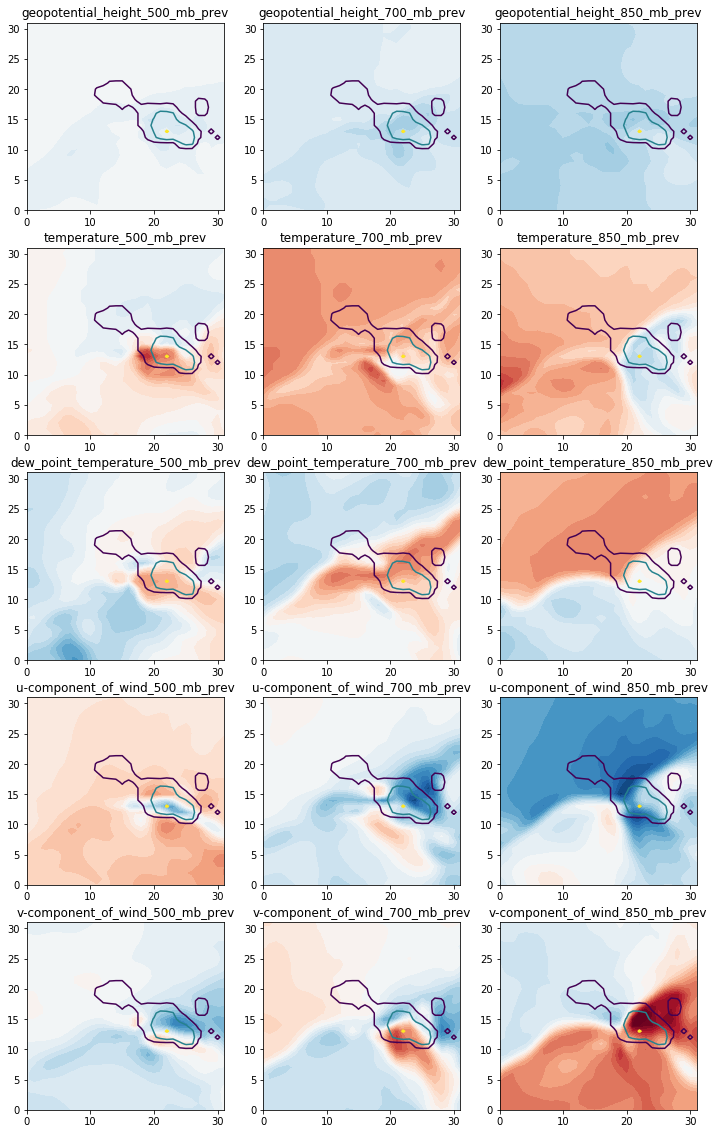

In [64]:
fig, axes = plt.subplots(5, 3, figsize=(12, 20))
start_c = 1
channels = [start_c, start_c + 5, start_c + 10]
a = 0
ex = 59562
for (r, c), ax in np.ndenumerate(axes):
    ax.contourf((ua_data[ex, :, :, a] - means[a]) / sds[a], np.arange(-4, 4.25, 0.25), cmap="RdBu_r", extend="both")
    ax.contour(patch_label_data[ex, :, :, 1], [5, 25, 50], cmap="viridis")
    ax.set_title(ua_vars[a])
    a+= 1

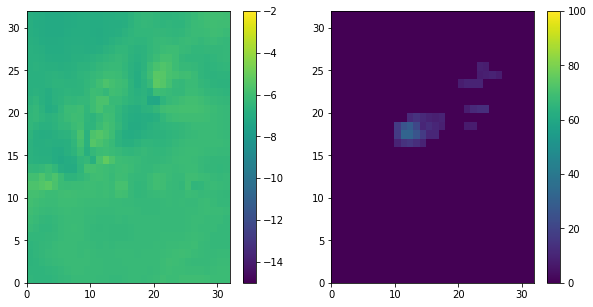

In [43]:
ex = 15325
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh((ua_data[ex, :, :, 3] - ua_data[ex, :, :, 4]) / (ua_data[ex, :, :, 0] - ua_data[ex, :, :, 1]) * 1000,
               vmin=-15, vmax=-2)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(patch_label_data[ex, :, :, 1] * 1000, vmin=0, vmax=100)
plt.colorbar()

In [46]:
lapse_rates = (ua_data[:, :, :, 3] - ua_data[:, :, :, 4]) / (ua_data[:, :, :, 0] - ua_data[:, :, :, 1]) * 1000

In [48]:
mean_lr = lapse_rates.mean(axis=-1).mean(axis=-1)

In [ ]:
storm_data, storm_centers, storm_dates = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", variable_names)

In [10]:
patch_label_vars = ["mask", 'thompson_max_hail_k1_surface_current']
patch_label_data, patch_label_centers, patch_label_dates = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", patch_label_vars)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc
/scr

In [13]:
mask_size = patch_label_data[:, :, :, 0].sum(axis=-1).sum(axis=-1)

In [12]:
patch_label_data[:, :, :, 1] = patch_label_data[:, :, :, 1] * 1000

In [14]:
max_hail = np.array([patch_label_data[i, :, :, 1][patch_label_data[i, :, :, 0] == 1].max() for i in range(patch_label_data.shape[0])])

(array([  7.62910000e+04,   1.18820000e+04,   8.21700000e+03,
          5.54600000e+03,   5.05500000e+03,   1.91500000e+03,
          3.90600000e+03,   1.10100000e+03,   2.82000000e+02,
          3.40000000e+01]),
 array([  0.        ,   9.60299988,  19.20599976,  28.80899963,
         38.41199951,  48.01499939,  57.61799927,  67.22099915,
         76.82399902,  86.4269989 ,  96.02999878]),
 <a list of 10 Patch objects>)

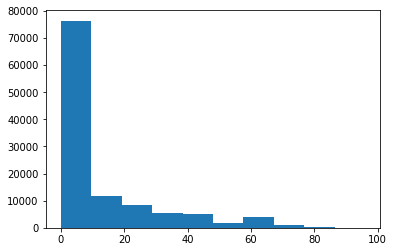

In [15]:
plt.hist(max_hail)

In [32]:
sev_hail = np.where(max_hail >= 25, 1, 0)

In [17]:
ua_norm.shape

(114229, 32, 32, 15)

In [139]:
ua_input = Input(shape=(32, 32, 15))
for n, num_filters in enumerate([16, 32, 64]):
    if n == 0:
        #ua_cnn = Dropout(0.5)(ua_input)
        ua_cnn = Conv2D(num_filters, 4, strides=2, padding="same", kernel_regularizer=l2())(ua_input)
    else:
        ua_cnn = Dropout(0.5)(ua_cnn)
        ua_cnn = Conv2D(num_filters, 4, strides=2, padding="same", kernel_regularizer=l2())(ua_cnn)
    ua_cnn = LeakyReLU(alpha=0.2)(ua_cnn)
ua_cnn = Flatten()(ua_cnn)
ua_cnn = Dropout(0.5)(ua_cnn)
ua_cnn = Dense(1)(ua_cnn)
ua_cnn = Activation("sigmoid")(ua_cnn)
ua_cnn_model = Model(ua_input, ua_cnn)
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
ua_cnn_model.compile(opt, "mse")
print(ua_cnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 16)        3856      
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 8, 8, 32)          8224      
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 8, 8, 32)          0         
__________

In [140]:
ua_cnn_model.fit(ua_norm[train_indices], 
                 sev_hail[train_indices], 
                 epochs=20, batch_size=32, 
                 validation_split=0.1, verbose=2)

Train on 73486 samples, validate on 8166 samples
Epoch 1/20
15s - loss: 0.6573 - val_loss: 0.4137
Epoch 2/20
14s - loss: 0.3315 - val_loss: 0.2163
Epoch 3/20
15s - loss: 0.2017 - val_loss: 0.1412
Epoch 4/20
15s - loss: 0.1500 - val_loss: 0.1093
Epoch 5/20
15s - loss: 0.1288 - val_loss: 0.0966
Epoch 6/20
15s - loss: 0.1198 - val_loss: 0.0918
Epoch 7/20
15s - loss: 0.1162 - val_loss: 0.0873
Epoch 8/20
15s - loss: 0.1144 - val_loss: 0.0907
Epoch 9/20
15s - loss: 0.1132 - val_loss: 0.0857
Epoch 10/20
15s - loss: 0.1126 - val_loss: 0.0861
Epoch 11/20
15s - loss: 0.1123 - val_loss: 0.0877
Epoch 12/20
15s - loss: 0.1118 - val_loss: 0.0849
Epoch 13/20
15s - loss: 0.1115 - val_loss: 0.0859
Epoch 14/20
15s - loss: 0.1109 - val_loss: 0.0848
Epoch 15/20
15s - loss: 0.1110 - val_loss: 0.0861
Epoch 16/20
15s - loss: 0.1106 - val_loss: 0.0859
Epoch 17/20
15s - loss: 0.1107 - val_loss: 0.0866
Epoch 18/20
15s - loss: 0.1101 - val_loss: 0.0861
Epoch 19/20
15s - loss: 0.1101 - val_loss: 0.0845
Epoch 20/2

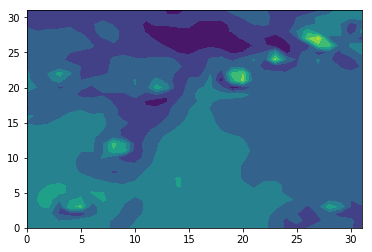

In [129]:
plt.contourf(ua_norm[test_indices][0][:, :, 4])

In [141]:
cnn_preds = ua_cnn_model.predict(ua_norm[test_indices])

In [146]:
rel = DistributedReliability()
rel.update(cnn_preds[:, 0], sev_hail[test_indices])
print(rel.brier_score())
print(rel.brier_skill_score())

0.105067609049
0.292028882195


Index(['Bin_Start', 'Bin_End', 'Bin_Center', 'Positive_Relative_Freq',
       'Total_Relative_Freq'],
      dtype='object')


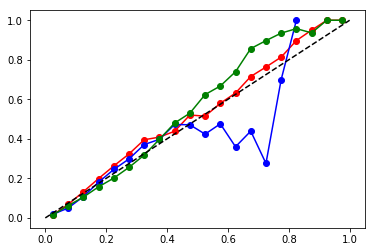

In [193]:
rel_curve = rel.reliability_curve()
lr_rel_curve = lr_rel.reliability_curve()
rf_rel_curve = rf_rel.reliability_curve()
print(rel_curve.columns)
plt.plot(rel_curve["Bin_Center"], rel_curve["Positive_Relative_Freq"], 'ro-')
plt.plot(lr_rel_curve["Bin_Center"], lr_rel_curve["Positive_Relative_Freq"], 'bo-')
plt.plot(rf_rel_curve["Bin_Center"], rf_rel_curve["Positive_Relative_Freq"], 'go-')

#plt.gca().set_yscale("log")
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'k--')

In [148]:
lr_rel = DistributedReliability()
lr_rel.update(lr_preds[:, 1], sev_hail[test_indices])
print(lr_rel.brier_score())
print(lr_rel.brier_skill_score())

0.133200417472
0.102463172967


In [138]:
coef_ranks = np.abs(lr_ua.coef_[0]).argsort()[::-1]
for coef_rank in coef_ranks:
    print(ua_vars[coef_rank], lr_ua.coef_[0][coef_rank])

geopotential_height_500_mb_prev -2.49650446175
geopotential_height_850_mb_prev 1.36135085231
dew_point_temperature_850_mb_prev 1.07041983525
temperature_850_mb_prev 0.889050632734
u-component_of_wind_850_mb_prev -0.582331423598
v-component_of_wind_850_mb_prev -0.43964498705
temperature_700_mb_prev 0.342519744423
dew_point_temperature_700_mb_prev 0.256799304838
u-component_of_wind_700_mb_prev 0.204939431707
v-component_of_wind_500_mb_prev -0.143567251429
temperature_500_mb_prev -0.100097053153
u-component_of_wind_500_mb_prev 0.0509613636609
v-component_of_wind_700_mb_prev 0.0
dew_point_temperature_500_mb_prev 0.0
geopotential_height_700_mb_prev 0.0


In [158]:
pc_objs = []
means = []
sds = []
num_comps = 5
num_vars = ua_norm.shape[-1]
pc_train_data = np.zeros((train_indices.size, num_comps * num_vars), dtype=np.float32)
pc_test_data = np.zeros((test_indices.size, num_comps * num_vars), dtype=np.float32)
for v in range(num_vars):
    print(v, ua_vars[v])
    pc_objs.append(PCA(n_components=num_comps))
    var_data = ua_norm[:, :, :, v].reshape(-1, ua_norm.shape[1] * ua_norm.shape[2])
    pc_train_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].fit_transform(var_data[train_indices])
    pc_test_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].transform(var_data[test_indices])
    del var_data

0 geopotential_height_500_mb_prev
1 geopotential_height_700_mb_prev
2 geopotential_height_850_mb_prev
3 temperature_500_mb_prev
4 temperature_700_mb_prev
5 temperature_850_mb_prev
6 dew_point_temperature_500_mb_prev
7 dew_point_temperature_700_mb_prev
8 dew_point_temperature_850_mb_prev
9 u-component_of_wind_500_mb_prev
10 u-component_of_wind_700_mb_prev
11 u-component_of_wind_850_mb_prev
12 v-component_of_wind_500_mb_prev
13 v-component_of_wind_700_mb_prev
14 v-component_of_wind_850_mb_prev


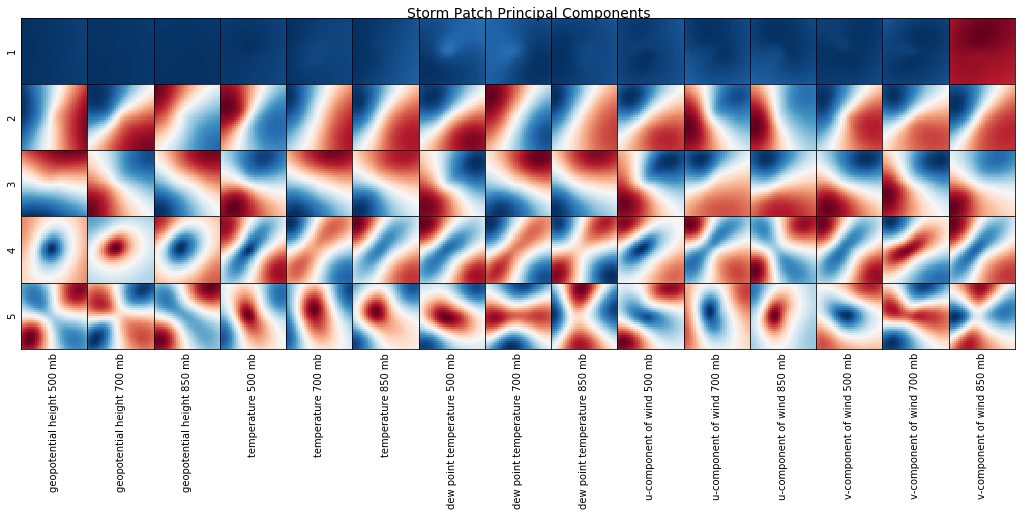

In [169]:
vis_comps = 5
fig, axes = plt.subplots(vis_comps, num_vars, figsize=(15, 5))
plt.subplots_adjust(0.03, 0.03, 0.95, 0.95, wspace=0, hspace=0)
#cax = fig.add_axes([0.96, 0.04, 0.03, 0.9])
p_ex = np.round(np.max([np.maximum(np.abs(pc_obj.components_.min()), 
                                  pc_obj.components_.max()) for pc_obj in pc_objs]),2)
for p, pc_obj in enumerate(pc_objs):
    for v in range(vis_comps):
        p_ex = np.round(np.max(np.abs(pc_obj.components_[v])), decimals=4)
        cont = axes[v, p].pcolormesh(pc_obj.components_[v].reshape(32, 32), 
                                     cmap="RdBu_r", vmin=-p_ex, vmax=p_ex)
        axes[v, p].axes.get_xaxis().set_ticks([])
        axes[v, p].axes.get_yaxis().set_ticks([])
        axes[v, 0].set(ylabel=v + 1)
    axes[-1, p].set_xlabel(ua_vars[p].rstrip("_prev").replace("_", " "), rotation=90)
#cbar = fig.colorbar(cont, cax=cax)
#cbar.ax.tick_params(labelsize=12)
fig.suptitle("Storm Patch Principal Components", y=0.98, fontsize=14)
plt.savefig("/scratch/dgagne/hail_models/storm_patch_field_pca.png", dpi=250, bbox_inches="tight")

In [179]:
lr_pca = LogisticRegression(penalty="l1", C=0.001,verbose=2)
lr_pca.fit(pc_train_data, sev_hail[train_indices])
lr_pca_preds = lr_pca.predict_proba(pc_test_data)[:, 1]

[LibLinear]

In [180]:
coef_ranks = np.abs(lr_pca.coef_[0]).argsort()[::-1]
for coef_rank in coef_ranks:
    ua_var = ua_vars[int(np.floor(coef_rank / num_comps))]
    ua_var_comp = coef_rank % num_comps
    print(ua_var, ua_var_comp, lr_pca.coef_[0][coef_rank])

geopotential_height_700_mb_prev 3 -0.163220395349
geopotential_height_500_mb_prev 0 0.122772551851
geopotential_height_500_mb_prev 3 0.103362407693
geopotential_height_850_mb_prev 0 -0.0782363604677
u-component_of_wind_700_mb_prev 1 0.0484675944082
dew_point_temperature_850_mb_prev 0 -0.04432253289
u-component_of_wind_850_mb_prev 1 0.0435382839745
temperature_850_mb_prev 0 -0.0369473553143
v-component_of_wind_850_mb_prev 2 0.0354624205249
v-component_of_wind_700_mb_prev 1 0.0302076358266
u-component_of_wind_850_mb_prev 2 -0.0289432065486
u-component_of_wind_500_mb_prev 2 0.0287559573578
v-component_of_wind_500_mb_prev 4 -0.0237066371016
dew_point_temperature_700_mb_prev 4 0.0232163136796
v-component_of_wind_500_mb_prev 1 0.0205210836308
u-component_of_wind_850_mb_prev 0 0.0189964991396
temperature_700_mb_prev 0 -0.0188479318726
u-component_of_wind_850_mb_prev 3 0.0148098063175
temperature_700_mb_prev 2 0.0140098302197
dew_point_temperature_700_mb_prev 1 0.013496803771
temperature_700_m

In [181]:
lr_pca_rel = DistributedReliability()
lr_pca_rel.update(lr_pca_preds, sev_hail[test_indices])
print(lr_pca_rel.brier_skill_score())

0.26660766621


In [182]:
rf_ua = RandomForestClassifier(n_estimators=100, max_features="sqrt")
rf_ua.fit(ua_norm_mean[train_indices], sev_hail[train_indices])
rf_ua_preds = lr_ua.predict_proba(ua_norm_mean[test_indices])[:, 1]

In [188]:
rf_pca = RandomForestClassifier(n_estimators=100, n_jobs=10, max_features="sqrt")
rf_pca.fit(pc_train_data, sev_hail[train_indices])
rf_pca_preds = rf_pca.predict_proba(pc_test_data)[:, 1]

In [189]:
rf_rel = DistributedReliability()
rf_rel.update(rf_pca_preds, sev_hail[test_indices])
print(rf_rel.brier_skill_score())

0.246715814204


In [191]:
coef_ranks = np.abs(rf_ua.feature_importances_).argsort()[::-1]
for coef_rank in coef_ranks:
    print(ua_vars[coef_rank], rf_ua.feature_importances_[coef_rank])

temperature_850_mb_prev 0.0877298803186
u-component_of_wind_850_mb_prev 0.0779885563687
dew_point_temperature_850_mb_prev 0.0747675735283
temperature_500_mb_prev 0.0717908807644
v-component_of_wind_850_mb_prev 0.0697601870837
temperature_700_mb_prev 0.0688626779796
dew_point_temperature_700_mb_prev 0.0641928985457
u-component_of_wind_500_mb_prev 0.0631733667265
geopotential_height_500_mb_prev 0.0630626189151
dew_point_temperature_500_mb_prev 0.0621598943272
geopotential_height_850_mb_prev 0.0601550222534
u-component_of_wind_700_mb_prev 0.0598745820153
geopotential_height_700_mb_prev 0.0596349422465
v-component_of_wind_500_mb_prev 0.0592565504525
v-component_of_wind_700_mb_prev 0.0575903684748


In [92]:
np.mean((cnn_preds[:, 0] - sev_hail[test_indices]) ** 2)

0.10232847696302715

In [94]:
sev_hail.shape

(114229,)

In [93]:
print((cnn_preds - sev_hail[test_indices]).shape )

(32577, 32577)


In [89]:
print(rel.brier_score())
print(rel.brier_skill_score())

0.103462719096
0.302843021245


In [76]:
np.mean((cnn_preds - sev_hail[test_indices]) ** 2)

0.1838134292616973

In [42]:
ua_norm_mean = np.zeros((ua_norm.shape[0], ua_norm.shape[-1]))
for v in range(ua_norm.shape[-1]):
    ua_norm_mean[:, v] = ua_norm[:, :, :, v].reshape(-1, 32 * 32).mean(axis=1)

In [44]:
lr_ua = LogisticRegression(penalty="l1", C=0.01)
lr_ua.fit(ua_norm_mean[train_indices], sev_hail[train_indices])
lr_preds = lr_ua.predict_proba(ua_norm_mean[test_indices])

In [45]:
np.mean((lr_preds[:, 1] - sev_hail[test_indices]) ** 2)

0.13255577629136936

In [46]:
np.mean((sev_hail[test_indices].mean() - sev_hail[test_indices]) ** 2)

0.14840663186235137

In [ ]:
storm_reports = pd.read_csv("http://www.spc.noaa.gov/wcm/data/2016_hail.csv", parse_dates={"datetime":["date", "time"]})
severe_reports = storm_reports.loc[storm_reports["mag"] >= 1]
severe_reports = severe_reports.reset_index()

In [36]:
severe_reports.columns

Index(['datetime', 'om', 'yr', 'mo', 'dy', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4'],
      dtype='object')

In [ ]:
def gc_distance(lon_1, lat_1, lon_2, lat_2):
    inv_lat_1 = np.radians(90 - lat_1)
    inv_lat_2 = np.radians(90 - lat_2)
    lon_1_rad = np.radians(lon_1)
    lon_2_rad = np.radians(lon_2)
    radius = 6373.0
    arc = np.arccos(np.sin(inv_lat_1) * np.sin(inv_lat_2) * np.cos(lon_1_rad - lon_2_rad) + np.cos(inv_lat_1) * np.cos(inv_lat_2))
    return radius * arc

In [11]:
severe_reports.shape

(7269, 28)

In [12]:
tdiff = pd.TimedeltaIndex(np.abs(severe_reports["datetime"].values - np.datetime64(storm_dates[0])))
tdiff.total_seconds() / 3600

array([ 2779.05      ,  2779.        ,  2779.        , ...,  5739.36666667,
        5740.41666667,  5740.65      ])

In [ ]:
has_severe_hail = np.zeros(storm_dates.size, dtype=np.int16)
min_severe_hail_distance = np.ones(storm_dates.size, dtype=np.float32) * np.nan
min_times = np.ones(storm_dates.size, dtype=np.float32)
for s in range(has_severe_hail.size):
    tdiff = pd.TimedeltaIndex(np.abs(severe_reports["datetime"].values - np.datetime64(storm_dates.values[s])))
    valid_times = np.where((tdiff.total_seconds() / 3600) < 4)[0]
    min_times[s] = (tdiff.total_seconds() / 3600).min()
    if len(valid_times) > 0:
        report_distances = gc_distance(storm_centers[s, 0], 
                                       storm_centers[s, 1], 
                                       severe_reports.loc[valid_times, "slon"], 
                                       severe_reports.loc[valid_times, "slat"])
        has_severe_hail[s] = np.count_nonzero(report_distances < 160)
        min_severe_hail_distance[s] = report_distances.min()

In [16]:
storm_patch_label_frame = pd.DataFrame({"lon": storm_centers[:, 0], 
                                        "lat": storm_centers[:, 1], 
                                        "valid_time": storm_dates,
                                        "report_count":has_severe_hail, 
                                        "min_severe_hail_distance": min_severe_hail_distance, 
                                         "min_time": min_times}, 
                                         columns=["valid_time", "lon", "lat", 
                                                  "report_count", "min_severe_hail_distance", "min_time"])
storm_patch_label_frame.to_csv("/scratch/dgagne/hail_models/hail_distance_labels.csv", index=False)

In [11]:
storm_patch_label_frame = pd.read_csv("/scratch/dgagne/hail_models/hail_distance_labels.csv")

In [17]:
np.nanpercentile(min_severe_hail_distance, [10, 25, 50, 75, 90])

array([   82.33264465,   168.22813416,   352.41934204,   760.2444458 ,
        1312.76967773])

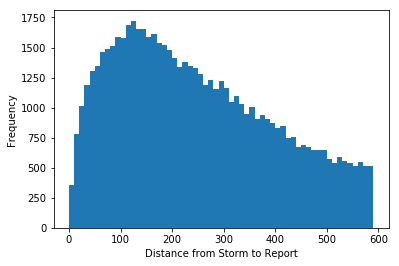

In [18]:
plt.hist(min_severe_hail_distance[~np.isnan(min_severe_hail_distance)], 
         bins=np.arange(0, 600, 10), cumulative=False)
plt.xlabel("Distance from Storm to Report")
plt.ylabel("Frequency")

(array([ 62031.,  13004.,  10274.,   8643.,   7649.,   5215.,   2950.,
          1713.,   1170.,    463.]),
 array([  0.        ,   1.0583333 ,   2.1166666 ,   3.1749999 ,
          4.23333321,   5.29166651,   6.34999981,   7.40833311,
          8.46666641,   9.52499971,  10.58333302]),
 <a list of 10 Patch objects>)

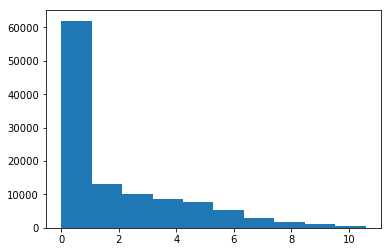

In [19]:
plt.hist(min_times)

In [20]:
for c in [2, 3]:
    storm_data[:, :, :, c] = np.sqrt(storm_data[:, :, :, c])

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


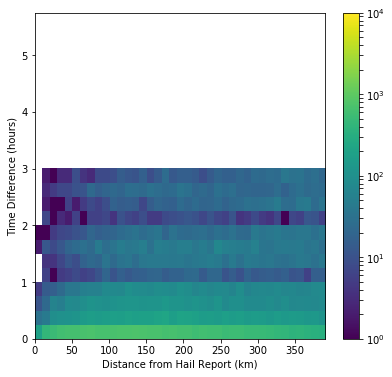

In [26]:
plt.figure(figsize=(6.5, 6))
plt.hist2d(min_severe_hail_distance, min_times, 
           bins=[np.arange(0, 400, 10), np.arange(0, 6, 0.25)], 
           norm=LogNorm(vmin=1, vmax=10000),cmin=1)
plt.colorbar()
plt.gca().set(xlabel="Distance from Hail Report (km)", ylabel="Time Difference (hours)")

In [157]:
np.nanpercentile(min_severe_hail_distance, 10)

81.685311658436007

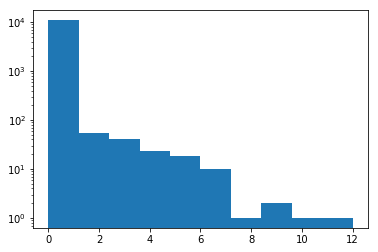

In [158]:
plt.hist(has_severe_hail)
plt.gca().set_yscale("log")

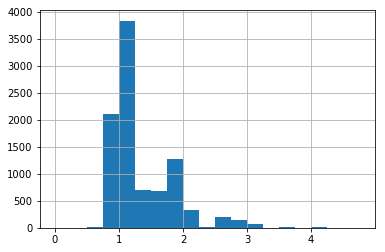

In [32]:
storm_reports["mag"].hist(bins=np.arange(0, 5, 0.25))

(array([ 17372801.,   7066324.,  12435941.,  18136456.,  19860252.,
         23683962.,  12010503.,   4148522.,   1043929.,     67998.]),
 array([-20.    ,  -9.6875,   0.625 ,  10.9375,  21.25  ,  31.5625,
         41.875 ,  52.1875,  62.5   ,  72.8125,  83.125 ]),
 <a list of 10 Patch objects>)

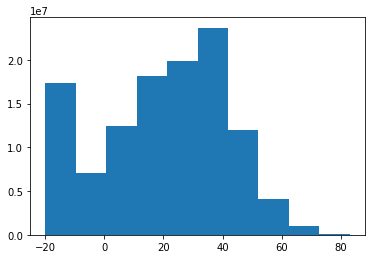

In [23]:
plt.hist(storm_data[:, :, :, 0].ravel())

In [32]:
storm_data[:, :, :, 4].mean()

3.8873699

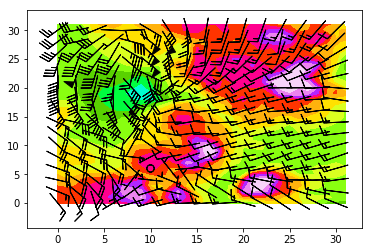

In [250]:
plt.contourf(storm_data[59560, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
plt.barbs(np.arange(0, 32, 2), np.arange(0, 32, 2), storm_data[59560, ::2, ::2, 4], storm_data[59560,::2,::2,5], pivot="middle")

In [27]:
unique_storm_dates = np.unique(storm_dates.date)
shuffled_storm_dates = np.random.permutation(unique_storm_dates)
split_point = int(0.7 * len(shuffled_storm_dates))
train_dates = np.sort(shuffled_storm_dates[:split_point])
test_dates = np.sort(shuffled_storm_dates[split_point:])
train_indices = np.where(np.in1d(storm_dates.date, train_dates))[0]
test_indices = np.where(np.in1d(storm_dates.date, test_dates))[0]

NameError: name 'storm_dates' is not defined

In [16]:
min_severe_hail_distance = storm_patch_label_frame["min_severe_hail_distance"].values
min_severe_hail_distance[np.isnan(min_severe_hail_distance)] = 9999999
train_labels = np.where(min_severe_hail_distance[train_indices] < 160, 1, 0)
test_labels = np.where(min_severe_hail_distance[test_indices] < 160, 1, 0)

In [210]:
train_labels = np.where(max_hail[train_indices] >= 25, 1, 0)
test_labels = np.where(max_hail[test_indices] >= 25, 1, 0)

In [81]:
train_labels.mean(), test_labels.mean()

(0.18363855658937625, 0.15608913998744509)

In [609]:
with open("/scratch/dgagne/hail_models/train_dates.pkl", "wb") as train_date_file:
    pickle.dump(train_dates, train_date_file)
with open("/scratch/dgagne/hail_models/test_dates.pkl", "wb") as test_date_file:
    pickle.dump(test_dates, test_date_file)

In [212]:
pc_objs = []
means = []
sds = []
num_comps = 10
num_vars = storm_data.shape[-1]
pc_train_data = np.zeros((train_indices.size, num_comps * num_vars), dtype=np.float32)
pc_test_data = np.zeros((test_indices.size, num_comps * num_vars), dtype=np.float32)
for v in range(num_vars):
    print(v)
    pc_objs.append(PCA(n_components=10))
    var_data = storm_data[:, :, :, v].reshape(-1, storm_data.shape[1] * storm_data.shape[2])
    means.append(var_data.mean())
    sds.append(var_data.std())
    norm_data = (var_data - means[v]) / sds[v]
    pc_train_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].fit_transform(norm_data[train_indices])
    pc_test_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].transform(norm_data[test_indices])

0
1
2
3
4
5


In [610]:
for p, pc_obj in enumerate(pc_objs):
    with open("/scratch/dgagne/hail_models/pc_obj_{0:d}.pkl".format(p), "wb") as pc_file:
        pickle.dump(pc_obj, pc_file, protocol=pickle.HIGHEST_PROTOCOL)

(array([  8.40000000e+01,   4.02000000e+02,   2.82400000e+03,
          4.32840000e+04,   3.86942800e+06,   2.65179470e+07,
          2.74679710e+07,   3.54791740e+07,   4.25210630e+07,
          4.77017180e+07,   5.11830660e+07,   5.36286590e+07,
          5.30860510e+07,   4.49446320e+07,   3.22885810e+07,
          2.24033460e+07,   1.41050390e+07,   6.10807300e+06,
          1.80974900e+06,   1.45661000e+05]),
 array([ 3.7516489 ,  3.99670758,  4.24176626,  4.48682494,  4.73188362,
         4.9769423 ,  5.22200098,  5.46705966,  5.71211834,  5.95717702,
         6.2022357 ,  6.44729438,  6.69235306,  6.93741174,  7.18247042,
         7.4275291 ,  7.67258778,  7.91764646,  8.16270514,  8.40776381,
         8.65282249]),
 <a list of 20 Patch objects>)

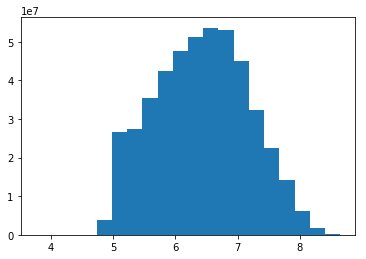

In [47]:
plt.hist(np.log(storm_data[:, :, :, 2].ravel()), bins=20)

In [29]:
short_var_names = ["Reflectivity", "Precipitable Water", "LCL Height", "CAPE", "0-6 km Shear-U", "0-6 km Shear-V"]

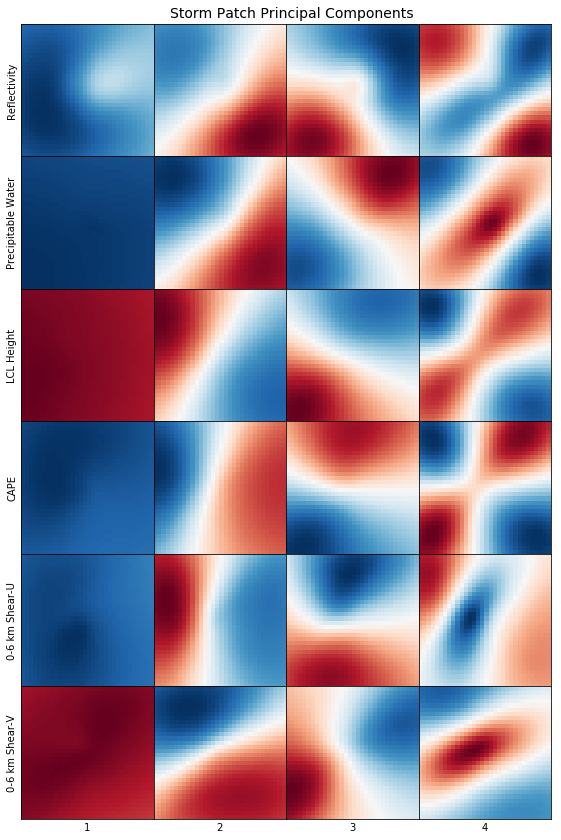

In [430]:
vis_comps = 4
fig, axes = plt.subplots(num_vars, vis_comps, figsize=(8, 12))
plt.subplots_adjust(0.03, 0.03, 0.95, 0.95, wspace=0, hspace=0)
#cax = fig.add_axes([0.96, 0.04, 0.03, 0.9])
p_ex = np.round(np.max([np.maximum(np.abs(pc_obj.components_.min()), 
                                  pc_obj.components_.max()) for pc_obj in pc_objs]),2)
for p, pc_obj in enumerate(pc_objs):
    for v in range(vis_comps):
        p_ex = np.round(np.max(np.abs(pc_obj.components_[v])), decimals=4)
        cont = axes[p, v].pcolormesh(pc_obj.components_[v].reshape(32, 32), 
                                     cmap="RdBu_r", vmin=-p_ex, vmax=p_ex)
        axes[p, v].axes.get_xaxis().set_ticks([])
        axes[p, v].axes.get_yaxis().set_ticks([])
        axes[-1, v].set(xlabel=v + 1)
    axes[p, 0].set(ylabel=short_var_names[p])
#cbar = fig.colorbar(cont, cax=cax)
#cbar.ax.tick_params(labelsize=12)
fig.suptitle("Storm Patch Principal Components", y=0.97, fontsize=14)
plt.savefig("/scratch/dgagne/hail_models/storm_patch_pca.png", dpi=250, bbox_inches="tight")

In [40]:
pc_objs[5].explained_variance_ratio_

array([ 0.64380208,  0.08320423,  0.05229771,  0.03013456,  0.02144564,
        0.01347508,  0.01136129,  0.00994684,  0.00812216,  0.00718102])

In [213]:
mv_means = []
mv_sds = []
mv_num_comps = 15
mv_num_vars = storm_data.shape[-1]
mv_pc_obj = PCA(n_components=mv_num_comps)
mv_pc_train_data = np.zeros((train_indices.size, mv_num_comps), dtype=np.float32)
mv_pc_test_data = np.zeros((test_indices.size, mv_num_comps), dtype=np.float32)
mv_norm_data = np.zeros((storm_data.shape[0], 64 * 64 * num_vars), dtype=np.float32)
for v in range(mv_num_vars):
    print(v)
    #if v == 2:
    #    var_data = np.sqrt(storm_data[:, :, :, v].reshape(-1, 64 * 64))
    #else:
    var_data = storm_data[:, :, :, v].reshape(-1, storm_data.shape[1] * storm_data.shape[2])
    mv_means.append(var_data.mean())
    mv_sds.append(var_data.std())
    mv_norm_data[:, 32 * 32 * v: 32 * 32 * (v + 1)] = (var_data - means[v]) / sds[v]
mv_pc_train_data[:, :] = mv_pc_obj.fit_transform(mv_norm_data[train_indices])
mv_pc_test_data[:, :] = mv_pc_obj.transform(mv_norm_data[test_indices])

0
1
2
3
4
5


In [60]:
mv_pc_obj.components_[0, 0:4096]

array([-0.00144565, -0.00145403, -0.00144767, ..., -0.00298122,
       -0.00299205, -0.00300172])

0.06
0 0 0.0073
0 1 0.015
0 2 0.0082
0 3 0.0121
1 0 0.023
1 1 0.0058
1 2 0.0073
1 3 0.0091
2 0 0.0219
2 1 0.0123
2 2 0.0067
2 3 0.0157
3 0 0.0137
3 1 0.0222
3 2 0.0127
3 3 0.0218
4 0 0.0054
4 1 0.0123
4 2 0.033
4 3 0.0034
5 0 0.0015
5 1 0.024
5 2 0.0093
5 3 0.0237


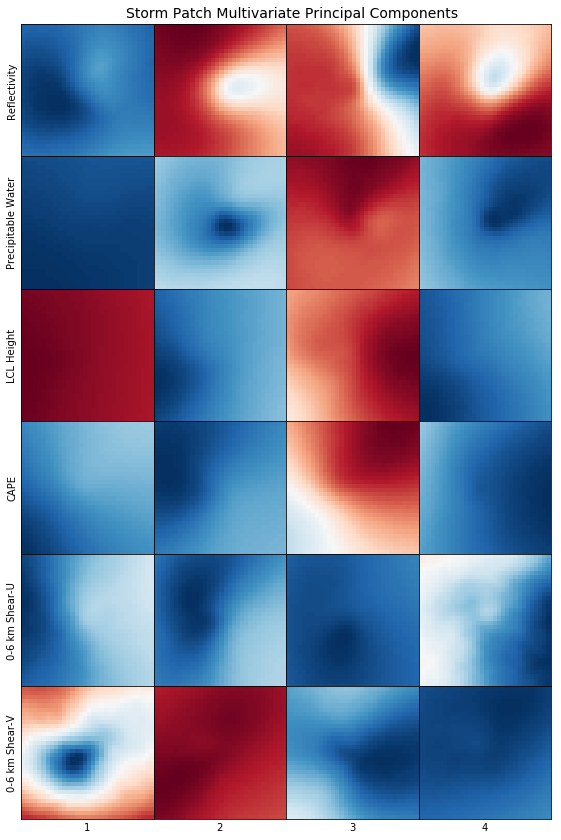

In [427]:
vis_comps = 4
fig, axes = plt.subplots(num_vars, vis_comps, figsize=(8, 12))
plt.subplots_adjust(0.03, 0.03, 0.95, 0.95, wspace=0, hspace=0)
p_ex = np.round(np.maximum(np.abs(mv_pc_obj.components_.min()), np.abs(mv_pc_obj.components_.max())), decimals=2)
print(p_ex)
#cax = fig.add_axes([0.96, 0.04, 0.03, 0.9])
for p in range(mv_num_vars):
    for v in range(vis_comps):
        pc_grid = mv_pc_obj.components_[v, 32 **2 * p: 32**2 * (p + 1)].reshape(32, 32)
        p_ex = np.round(np.max(np.abs(pc_grid)), decimals=4)
        print(p, v, p_ex)
        cont = axes[p, v].pcolormesh(pc_grid, 
                                   #np.linspace(-np.round(p_ex,2), np.round(p_ex, 2), 51), cmap="RdBu_r")
                                     vmin=-p_ex, vmax=p_ex, cmap="RdBu_r")
        axes[p, v].axes.get_xaxis().set_ticks([])
        axes[p, v].axes.get_yaxis().set_ticks([])
        axes[-1, v].set(xlabel=v + 1)
    axes[p, 0].set(ylabel=short_var_names[p])
#cbar = fig.colorbar(cont, cax=cax)
#cbar.ax.tick_params(labelsize=14)
fig.suptitle("Storm Patch Multivariate Principal Components", y=0.97, fontsize=14)
plt.savefig("/scratch/dgagne/hail_models/storm_patch_mv_pca.png", dpi=250, bbox_inches="tight")

In [611]:
with open("/scratch/dgagne/hail_models/mv_pc_obj.pkl", "wb") as mv_pc_file:
    pickle.dump(mv_pc_obj, mv_pc_file, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
mv_pc_obj.explained_variance_ratio_.cumsum()

array([ 0.25121981,  0.4116815 ,  0.53017828,  0.59428162,  0.64458871,
        0.68168505,  0.70307494,  0.72366048,  0.7396714 ,  0.75486835,
        0.76818766,  0.77822378,  0.78806537,  0.79629753,  0.80346482])

In [214]:
rf_mv = RandomForestClassifier(n_estimators=500, n_jobs=6, max_features="sqrt")
rf_mv.fit(mv_pc_train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=6, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [215]:
rf_mv.feature_importances_

array([ 0.07392249,  0.06753333,  0.06799333,  0.06781977,  0.0644245 ,
        0.09305537,  0.05745626,  0.0748186 ,  0.05678233,  0.06371958,
        0.06539361,  0.05990511,  0.05945565,  0.06870787,  0.0590122 ])

In [216]:
rf_mv_preds = rf_mv.predict_proba(mv_pc_test_data)[:, 1]

In [217]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=6, max_features="sqrt")
rf.fit(pc_train_data, train_labels)
rf_preds = rf.predict_proba(pc_test_data)[:, 1]

In [612]:
pickle.dump(rf, open("/scratch/dgagne/hail_models/hail_rf.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(rf_mv, open("/scratch/dgagne/hail_models/hail_rf_mv.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(logit, open("/scratch/dgagne/hail_models/hail_logit.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(logit_mv, open("/scratch/dgagne/hail_models/hail_logit_mv.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

(array([  7.46700000e+03,   8.47100000e+03,   6.78700000e+03,
          5.17700000e+03,   3.29800000e+03,   1.71600000e+03,
          6.64000000e+02,   2.07000000e+02,   4.90000000e+01,
          6.00000000e+00]),
 array([ 0.    ,  0.0706,  0.1412,  0.2118,  0.2824,  0.353 ,  0.4236,
         0.4942,  0.5648,  0.6354,  0.706 ]),
 <a list of 10 Patch objects>)

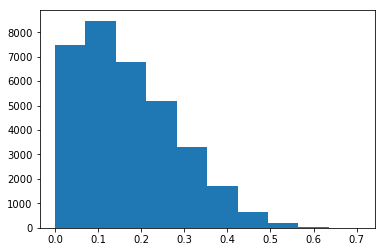

In [100]:
plt.hist(rf_preds)

In [218]:
logit_mv = LogisticRegression(penalty="l1")
logit_mv.fit(mv_pc_train_data, train_labels)
logit_mv_preds = logit_mv.predict_proba(mv_pc_test_data)[:, 1]

In [219]:
logit = LogisticRegression(penalty="l1")
logit.fit(pc_train_data, train_labels)
logit_preds = logit.predict_proba(pc_test_data)[:, 1]

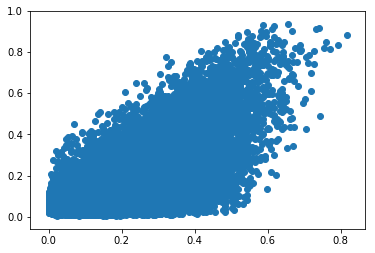

In [92]:
plt.scatter(rf_preds, logit_preds)

In [34]:
logit.coef_

array([[ 0.00410254, -0.00206951, -0.00654126,  0.00235539, -0.00701154,
         0.00216319, -0.00476771,  0.00142651,  0.00610242, -0.00016836,
         0.01656552,  0.02712975,  0.00357492,  0.0206493 ,  0.02383388,
        -0.01684514, -0.00341637,  0.0062114 , -0.00365573, -0.00946042,
         0.01847374, -0.00182606,  0.00297849,  0.00362054, -0.01020593,
         0.01486102, -0.00443039, -0.00279718, -0.00404756,  0.00174898,
        -0.00894072,  0.00694267,  0.00787597, -0.00852641, -0.00061422,
         0.00285988,  0.00311282,  0.00044144,  0.00055422,  0.00997964,
         0.0040147 ,  0.0025486 ,  0.00763022, -0.00820168,  0.01043601,
         0.00249809,  0.00232485, -0.00380224, -0.0044822 , -0.00505782]])

In [231]:
thresholds = np.array([0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
pred_list = [rf_preds, rf_mv_preds, logit_preds, logit_mv_preds, cnn_preds, ann_preds, gan_logit_preds]
rel_list = []
roc_list = []
for pred in pred_list:
    rel_list.append(DistributedReliability(thresholds=thresholds))
    rel_list[-1].update(pred, test_labels)
    roc_list.append(DistributedROC(thresholds=thresholds))
    roc_list[-1].update(pred, test_labels)
print([rel.brier_skill_score() for rel in rel_list])
print([roc.auc() for roc in roc_list])

[0.1315671651207819, 0.14319429069703118, 0.11733972780748661, 0.092368273262032119, 0.14000368408629912, 0.14516937255209295, 0.10239804710492349]
[0.74754380877742943, 0.74712490780011065, 0.72882908445509864, 0.70827025170569791, 0.74679063249124078, 0.74568527106767457, 0.71708746542504143]


In [597]:
rel = rel_list[0]
rel.brier_score_components()

(0.0045216460716312242, 0.0076600430996052876, 0.1187265914318528)

In [181]:
for r, rel in enumerate(rel_list):
    print(rel.brier_score_components())

(0.0021828865357890457, 0.017533414057522748, 0.13172532036542486)
(0.0019564524248473461, 0.020067114912054995, 0.13172532036542486)
(0.002050928956404071, 0.014814921638213099, 0.13172532036542486)
(0.0022989573494076598, 0.012562837036866406, 0.13172532036542486)
(0.0016605735383792685, 0.017279839289868145, 0.13172532036542486)
(0.0031937060191050835, 0.017260209686475944, 0.13172532036542486)
(0.0093866246558405326, 0.018641935605069521, 0.13172532036542486)
(0.0022110720100094552, 0.012524992500983578, 0.13172532036542486)


In [232]:
ml_model_names = ["Random Forest PCA", 
                  "Random Forest MV PCA", 
                  "Logistic Reg. PCA",
                  "Logistic Reg. MV PCA",
                  "Conv. Net",
                  "Dense Net MV PCA",
                  "Logistic Reg. GAN"]
pred_frame = pd.DataFrame(np.array([rf_preds, rf_mv_preds, logit_preds, logit_mv_preds, cnn_preds, ann_preds, gan_logit_preds]).T,
                          columns=ml_model_names)

In [515]:
paired_preds = pred_frame.iloc[:, [0, 4]]
paired_preds.values[np.arange(0, 34238), np.random.randint(0,1, size=paired_preds.shape[0])]

array([ 0.082,  0.122,  0.102, ...,  0.166,  0.118,  0.074])

In [52]:
def brier_score(pred, label):
    return np.mean((pred - label) ** 2)
ref_model = "Conv. Net"
num_permutations = 10000
bs_diff_dist = np.zeros((pred_frame.columns.size, num_permutations), dtype=np.float32)
bs_diffs = np.zeros(pred_frame.columns.size, dtype=np.float32)
for m, model in enumerate(pred_frame.columns):
    if model != ref_model:
        paired_preds = pred_frame[[model, ref_model]]
        shuffled_preds = np.zeros(paired_preds.shape, dtype=np.float32)
        bs_diffs[m] = brier_score(paired_preds[ref_model], test_labels) - brier_score(paired_preds[model], test_labels)
        #print(bs_diff)
        for p in range(num_permutations):
            flips = np.random.randint(0, 2, size=paired_preds.shape[0])
            shuffled_preds[:, 0] = paired_preds.values[np.arange(paired_preds.shape[0]), flips]
            shuffled_preds[:, 1] = paired_preds.values[np.arange(paired_preds.shape[0]), 1-flips]
            bs_diff_dist[m, p] = brier_score(shuffled_preds[:, 0], test_labels) - brier_score(shuffled_preds[:, 1], test_labels)
        print(model, bs_diffs[m], percentileofscore(bs_diff_dist, bs_diffs[m], "mean"))  

KeyboardInterrupt: 

In [520]:
for model in pred_frame.columns:
    bs_model = brier_score(pred_frame[model], test_labels)
    print("{0:25s}".format(model), "{0:0.4f}".format(bs_model), "{0:0.4f}".format(1 - bs_model / bs_climo))

Random Forest PCA         0.1221 0.0250
Random Forest MV PCA      0.1247 0.0037
Logistic Reg. PCA         0.1224 0.0223
Logistic Reg. MV PCA      0.1217 0.0279
Conv. Net                 0.1198 0.0429
Dense Net MV PCA          0.1283 -0.0245
Logitic Reg. GAN          0.1248 0.0033


In [449]:
climo_preds = np.ones(test_labels.size) * train_labels.mean()
bs_climo = brier_score(climo_preds, test_labels)

In [458]:
1 / 60.0

0.016666666666666666

In [461]:
np.where(rf.feature_importances_ - 1.0/60 > 0)

(array([ 0,  1,  2,  4, 10, 11, 20, 21, 30, 31, 32, 40, 41, 50]),)

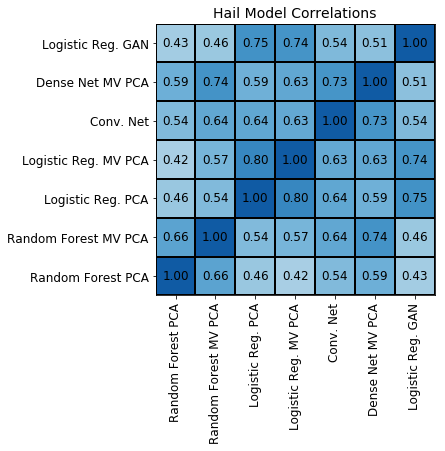

In [234]:
plt.figure(figsize=(5, 5))
r2_pred = np.corrcoef(pred_frame.values.T) ** 2
plt.pcolormesh(r2_pred, vmin=0, vmax=1.2, cmap="Blues", edgecolors="k")
plt.xticks(np.arange(7) + 0.5, ml_model_names, rotation=90, fontsize=12)
plt.yticks(np.arange(7) + 0.5, ml_model_names, rotation=0, fontsize=12)
for (i, j), v in np.ndenumerate(r2_pred):
    plt.text(i + 0.5, j + 0.5, "{0:0.2f}".format(v), ha="center", va="center", fontsize=12)
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.title("Hail Model Correlations", fontsize=14)
plt.savefig("/scratch/dgagne/hail_models/hail_model_corr.png", dpi=250, bbox_inches="tight")

In [190]:
len(ml_model_names)

7

In [235]:
ml_model_names = ["Random Forest PCA", 
                  "Random Forest MV PCA", 
                  "Logistic Reg. PCA",
                  "Logistic Reg. MV PCA",
                  "Conv. Net",
                  "Dense Net MV PCA",
                  "Logistic Reg. GAN"]
ml_model_colors = ["red", "pink", "blue", "cyan", "purple", "magenta", "skyblue"]
ml_model_symbols = ["o", "o", "v", "v", "s", "s", "v"]
roc_curve(roc_list, ml_model_names, ml_model_colors, ml_model_symbols, "/scratch/dgagne/hail_models/hail_prob_roc.png", figsize=(6, 6), 
          title="NCAR Storm Patch Severe Hail Probability ROC Curve")
performance_diagram(roc_list, ml_model_names, ml_model_colors, ml_model_symbols, "/scratch/dgagne/hail_models/hail_prob_perf.png", figsize=(6, 6), 
          title="NCAR Storm Patch Severe Hail Probability Performance Curve")

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/hagelslag-0.2-py3.5.egg/hagelslag/evaluation/MetricPlotter.py:122: RuntimeWarning: divide by zero encountered in true_divide
  bias = pod_g / sr_g
/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/hagelslag-0.2-py3.5.egg/hagelslag/evaluation/MetricPlotter.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias = pod_g / sr_g
/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/hagelslag-0.2-py3.5.egg/hagelslag/evaluation/MetricPlotter.py:123: RuntimeWarning: divide by zero encountered in true_divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


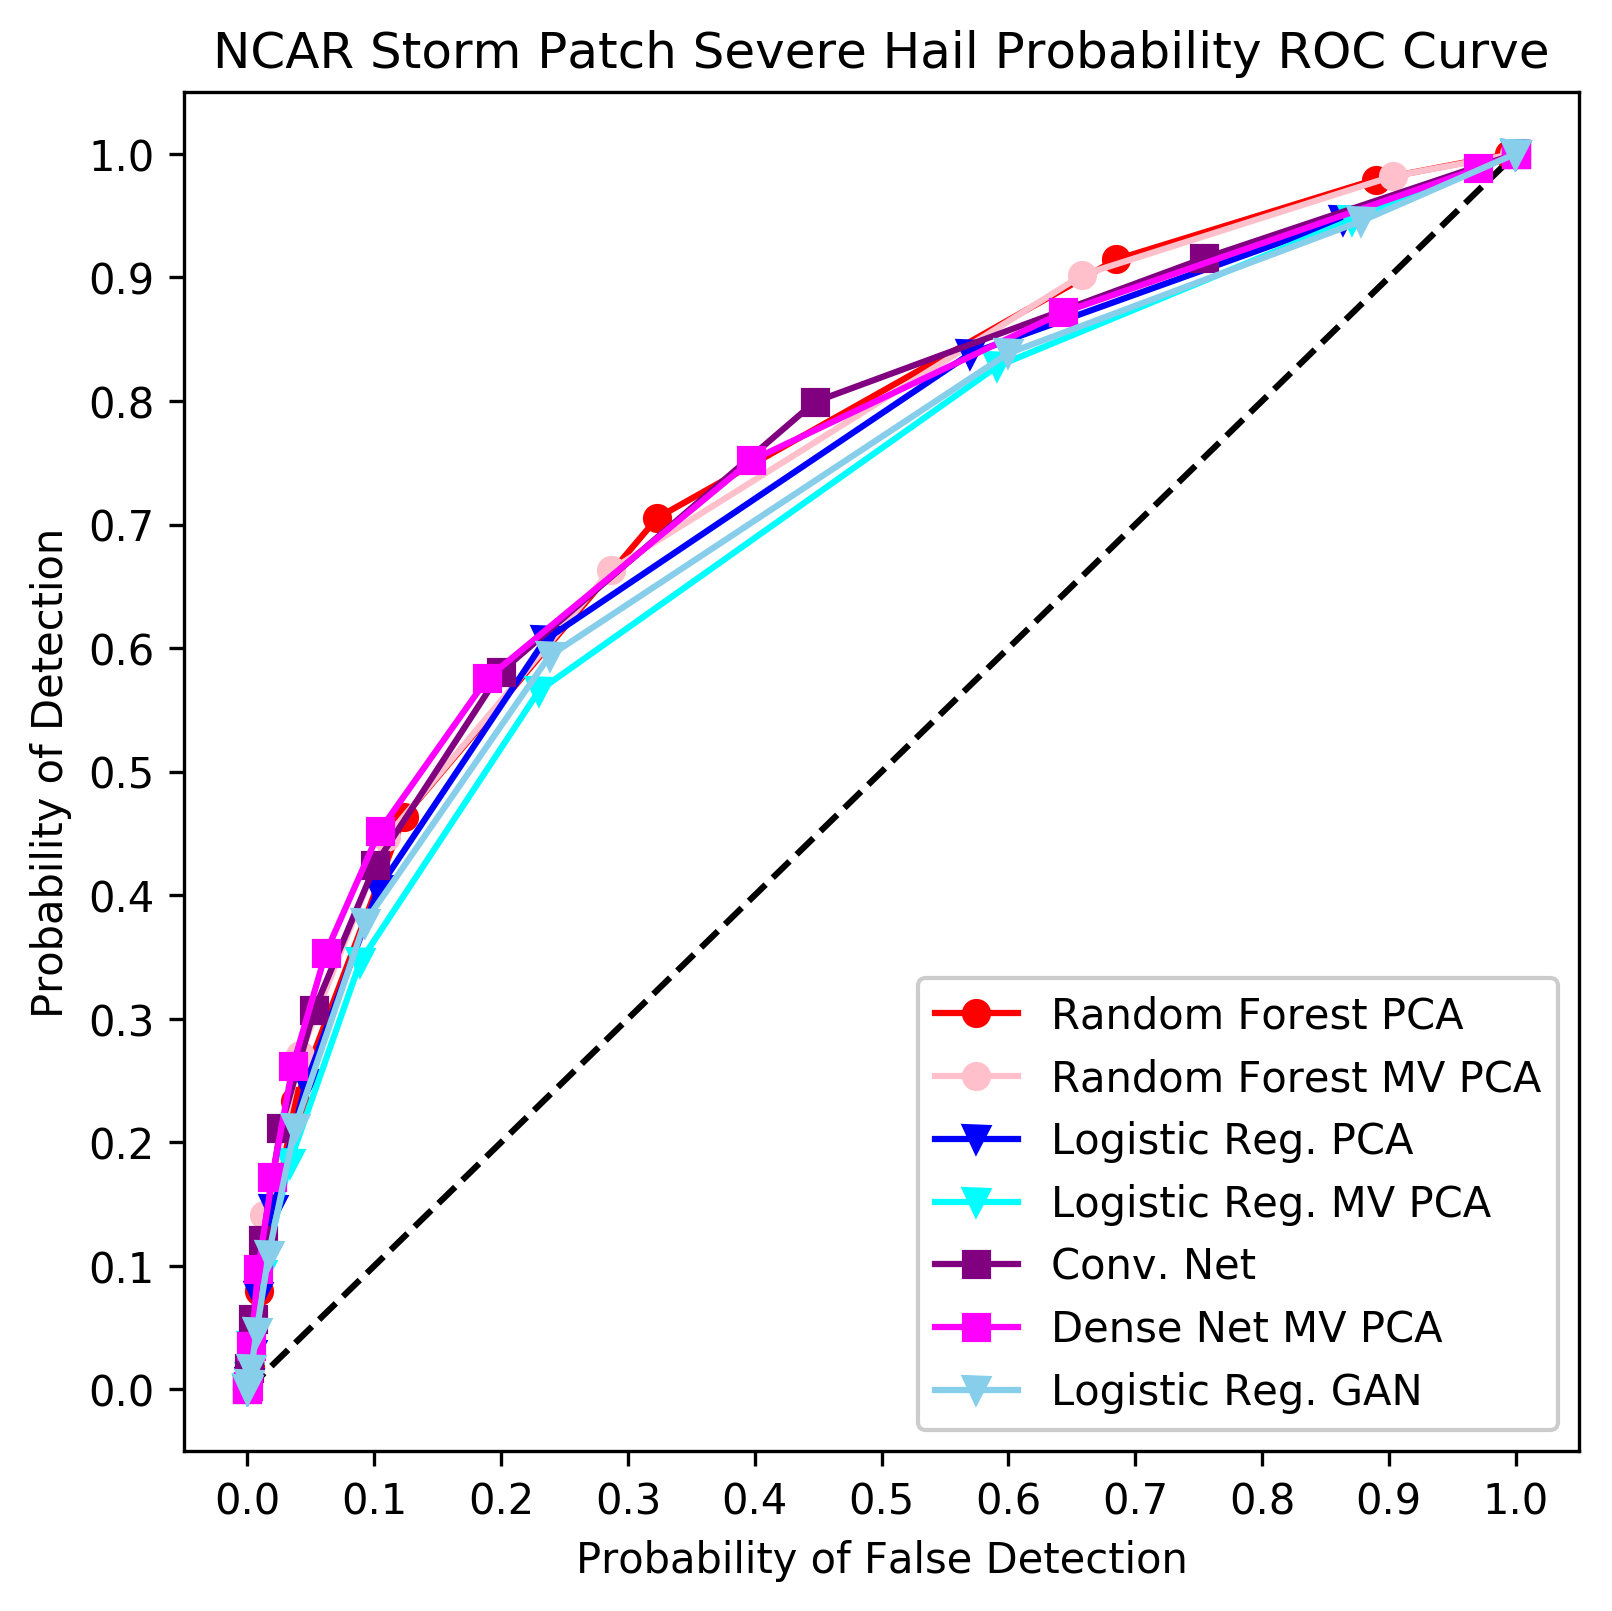

In [236]:
Image("/scratch/dgagne/hail_models/hail_prob_roc.png", width=500)

In [237]:
attributes_diagram(rel_list, ml_model_names,
                   ml_model_colors, ml_model_symbols, "/scratch/dgagne/hail_models/hail_prob_rel.png", figsize=(6, 6), 
                      title="NCAR Storm Patch Severe Hail Probability Reliability")

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


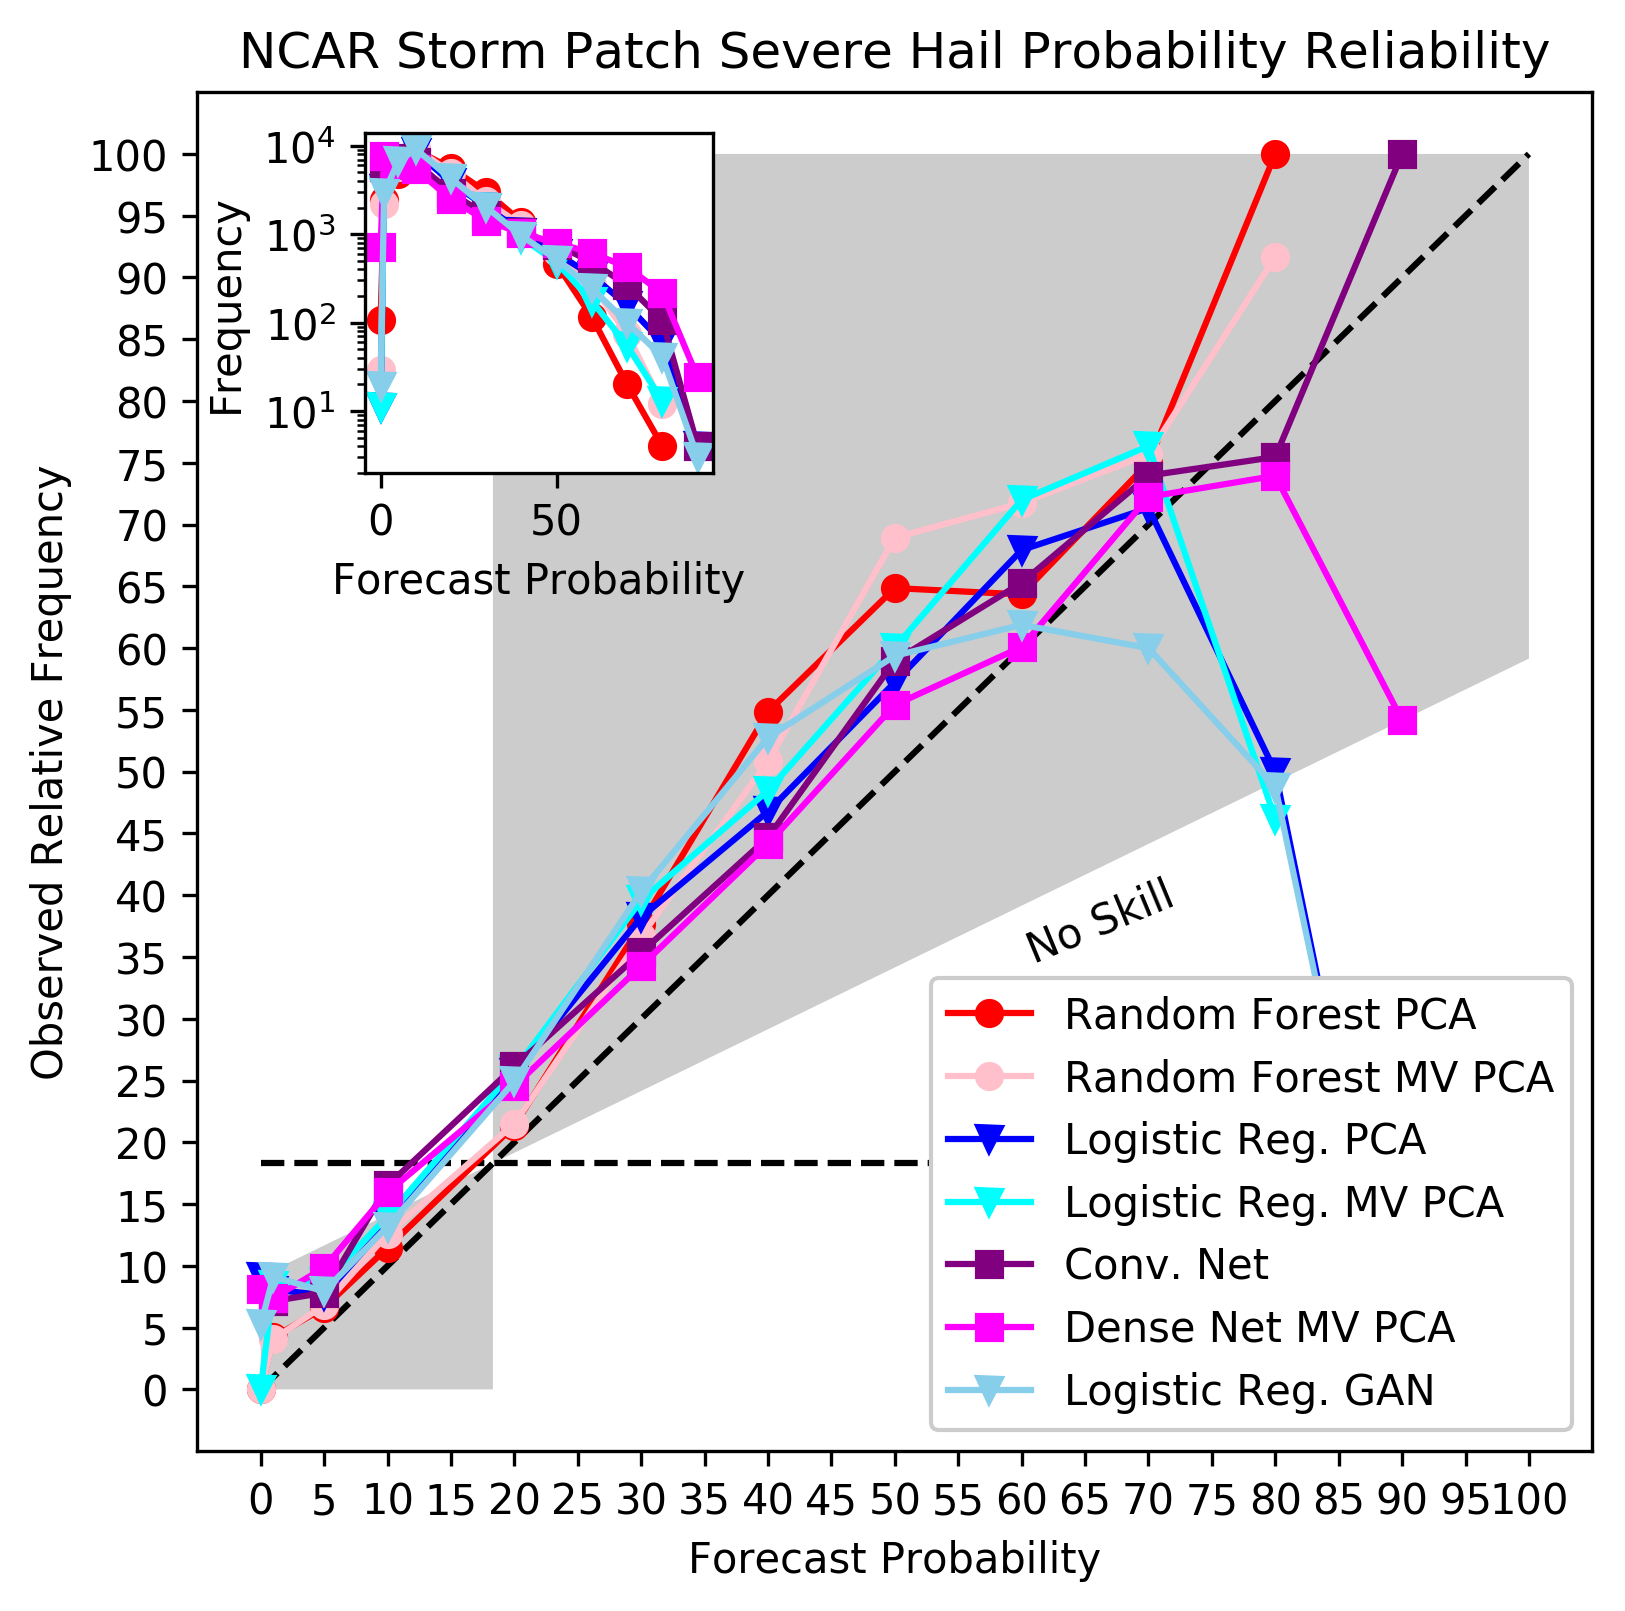

In [238]:
Image("/scratch/dgagne/hail_models/hail_prob_rel.png", width=500)

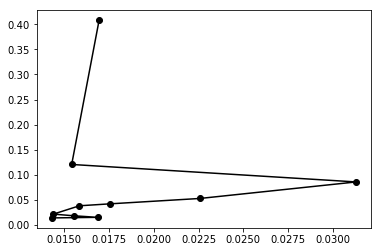

In [239]:
plt.plot(rf.feature_importances_[:10], pc_objs[0].explained_variance_ratio_, 'ko-')

In [240]:
pc_objs[0].explained_variance_ratio_

array([ 0.40811787,  0.12044554,  0.08557582,  0.05259705,  0.04186855,
        0.03799221,  0.02137064,  0.01810206,  0.01496377,  0.01380681])

In [123]:
def hail_patch_model(input_size=(32, 32, 6), filter_width=5, min_data_width=4,
                    min_conv_filters=64, stride=2):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="patch_input")
    model = None
    for c in range(num_layers):
        if c == 0:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same",
                           kernel_initializer="lecun_normal",
                           kernel_regularizer=l2())(image_input)
        else:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same",
                           kernel_initializer="lecun_normal",
                           kernel_regularizer=l2())(model)
        model = Activation("selu")(model)
        #model = AlphaDropout(0.3)(model)
        #model = BatchNormalization()(model)
        curr_conv_filters *= 2
    model = Flatten()(model)
    model = Dense(1, kernel_regularizer=l2())(model)
    model = Activation("sigmoid")(model)
    return model, image_input

In [21]:
num_vars = 6
storm_norm_data = np.zeros(storm_data.shape, dtype=np.float32)
for i in range(num_vars):
    storm_norm_data[:, :, :, i] = (storm_data[:, :, :, i] - means[i]) / sds[i]

In [221]:
hail_cnn, hail_cnn_input = hail_patch_model(min_conv_filters=10, filter_width=5, min_data_width=4)
hail_cnn_model = Model(hail_cnn_input, hail_cnn)
hail_cnn_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9), loss="mse")
#hail_cnn_model.compile(optimizer="rmsprop", loss="mse")
hail_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_input (InputLayer)     (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 16, 16, 10)        1510      
_________________________________________________________________
activation_192 (Activation)  (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 8, 8, 20)          5020      
_________________________________________________________________
activation_193 (Activation)  (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 4, 4, 40)          20040     
_________________________________________________________________
activation_194 (Activation)  (None, 4, 4, 40)          0         
__________

In [121]:
train_labels.mean()

4.5840985702661863

In [222]:
class_weights = class_weight.compute_class_weight("balanced", [0, 1], train_labels)
cnn_hist = hail_cnn_model.fit(storm_norm_data[train_indices],
                              train_labels, batch_size=256,
                              validation_split=0.2, epochs=20, verbose=2)

Train on 68945 samples, validate on 17237 samples
Epoch 1/20
6s - loss: 0.3000 - val_loss: 0.2038
Epoch 2/20
5s - loss: 0.1417 - val_loss: 0.1629
Epoch 3/20
5s - loss: 0.1291 - val_loss: 0.1638
Epoch 4/20
5s - loss: 0.1252 - val_loss: 0.1627
Epoch 5/20
5s - loss: 0.1234 - val_loss: 0.1628
Epoch 6/20
5s - loss: 0.1235 - val_loss: 0.1606
Epoch 7/20
5s - loss: 0.1231 - val_loss: 0.1646
Epoch 8/20
5s - loss: 0.1230 - val_loss: 0.1662
Epoch 9/20
5s - loss: 0.1228 - val_loss: 0.1590
Epoch 10/20
5s - loss: 0.1227 - val_loss: 0.1576
Epoch 11/20
5s - loss: 0.1230 - val_loss: 0.1701
Epoch 12/20
5s - loss: 0.1227 - val_loss: 0.1638
Epoch 13/20
5s - loss: 0.1226 - val_loss: 0.1572
Epoch 14/20
5s - loss: 0.1225 - val_loss: 0.1608
Epoch 15/20
5s - loss: 0.1224 - val_loss: 0.1610
Epoch 16/20
5s - loss: 0.1224 - val_loss: 0.1557
Epoch 17/20
5s - loss: 0.1224 - val_loss: 0.1625
Epoch 18/20
5s - loss: 0.1221 - val_loss: 0.1584
Epoch 19/20
5s - loss: 0.1223 - val_loss: 0.1611
Epoch 20/20
5s - loss: 0.122

(15775, 32, 32, 6)

In [223]:
cnn_preds = hail_cnn_model.predict(storm_norm_data[test_indices])[:, 0]

(array([  4578.,  10741.,   7263.,   4158.,   2651.,   1800.,   1292.,
          1012.,    637.,    106.]),
 array([ 0.0085318 ,  0.08866124,  0.16879068,  0.24892012,  0.32904956,
         0.409179  ,  0.48930844,  0.56943788,  0.64956732,  0.72969676,
         0.8098262 ]),
 <a list of 10 Patch objects>)

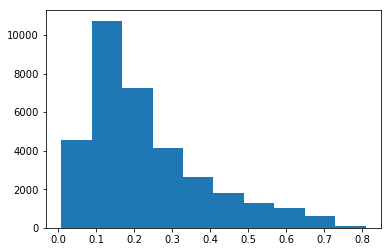

In [244]:
plt.hist(cnn_preds)

(0, 0.9)

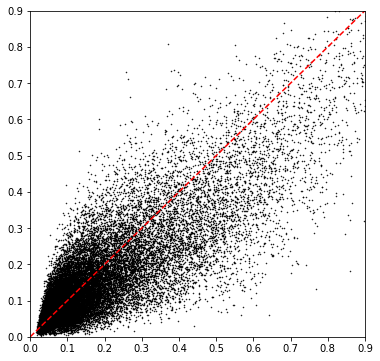

In [132]:
plt.figure(figsize=(6,6))
plt.scatter(cnn_preds, logit_preds, 1, 'k', marker='.')
plt.plot(np.linspace(0, 0.9, 10), np.linspace(0,0.9, 10), 'r--')
plt.xlim(0, 0.9)
plt.ylim(0, 0.9)

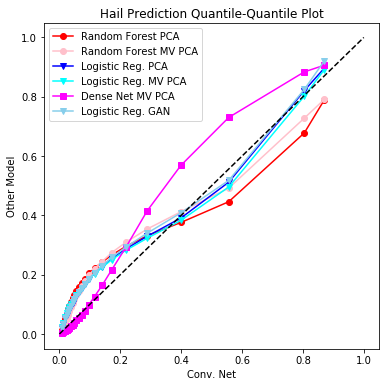

In [133]:
plt.figure(figsize=(6, 6))
quantiles = np.concatenate([[0.1], np.arange(1, 100, 5), [99.9, 99.99]])
for m, model in enumerate(pred_frame.columns):
    if model != ref_model:
        plt.plot(np.percentile(pred_frame[ref_model], quantiles), 
                 np.percentile(pred_frame[model], quantiles), marker=ml_model_symbols[m], linestyle="-", 
                 color=ml_model_colors[m], label=model)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10),'k--')
plt.legend()
plt.xlabel(ref_model)
plt.ylabel("Other Model")
plt.title("Hail Prediction Quantile-Quantile Plot")
plt.savefig("/scratch/dgagne/hail_models/hail_model_qq_plot.png", dpi=250, bbox_inches="tight")

In [224]:
ann_input = Input(shape=(mv_pc_train_data.shape[1], ))
ann_model = Dense(64, kernel_regularizer=l2())(ann_input)
ann_model = Activation("selu")(ann_model)
#ann_model = AlphaDropout(0.2)(ann_model)
ann_model = Dense(64, kernel_regularizer=l2())(ann_model)
ann_model = Activation("selu")(ann_model)
#ann_model = AlphaDropout(0.2)(ann_model)
ann_model = Dense(1)(ann_model)
ann_model = Activation("sigmoid")(ann_model)
ann_obj = Model(ann_input, ann_model)
ann_obj.compile(optimizer=Adam(lr=0.001, beta_1=0.9), loss="mse")
ann_obj.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1024      
_________________________________________________________________
activation_196 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_197 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_198 (Activation)  (None, 1)                 0         
Total para

In [225]:
ann_hist = ann_obj.fit(mv_pc_train_data,
                       train_labels, batch_size=256,
                       validation_split=0.2, epochs=20, verbose=2)

Train on 68945 samples, validate on 17237 samples
Epoch 1/20
1s - loss: 0.4717 - val_loss: 0.2541
Epoch 2/20
0s - loss: 0.1639 - val_loss: 0.1796
Epoch 3/20
0s - loss: 0.1258 - val_loss: 0.1678
Epoch 4/20
0s - loss: 0.1168 - val_loss: 0.1657
Epoch 5/20
0s - loss: 0.1138 - val_loss: 0.1570
Epoch 6/20
0s - loss: 0.1131 - val_loss: 0.1622
Epoch 7/20
0s - loss: 0.1118 - val_loss: 0.1633
Epoch 8/20
0s - loss: 0.1125 - val_loss: 0.1556
Epoch 9/20
0s - loss: 0.1117 - val_loss: 0.1599
Epoch 10/20
0s - loss: 0.1118 - val_loss: 0.1558
Epoch 11/20
0s - loss: 0.1117 - val_loss: 0.1615
Epoch 12/20
0s - loss: 0.1113 - val_loss: 0.1556
Epoch 13/20
0s - loss: 0.1113 - val_loss: 0.1615
Epoch 14/20
0s - loss: 0.1116 - val_loss: 0.1568
Epoch 15/20
0s - loss: 0.1114 - val_loss: 0.1598
Epoch 16/20
0s - loss: 0.1114 - val_loss: 0.1544
Epoch 17/20
0s - loss: 0.1113 - val_loss: 0.1579
Epoch 18/20
0s - loss: 0.1113 - val_loss: 0.1563
Epoch 19/20
0s - loss: 0.1110 - val_loss: 0.1589
Epoch 20/20
0s - loss: 0.110

In [226]:
ann_preds = ann_obj.predict(mv_pc_test_data)[:, 0]

In [293]:
400 / 5

80.0

In [608]:
hail_cnn_model.save("/scratch/dgagne/hail_models/hail_cnn.h5")

In [43]:
gan_encoder = load_model("/scratch/dgagne/storm_gan_20170622/gan_encoder_000004_epoch_0010.h5")

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-2.0.6-py3.5.egg/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [44]:
scaled_storm_data = rescale_multivariate_data(storm_data)

In [45]:
gan_encoded_data = gan_encoder.predict(scaled_storm_data)

In [566]:
gan_rf = RandomForestClassifier(n_estimators=500, n_jobs=2, max_features="sqrt")
gan_rf.fit(gan_encoded_data[train_indices], train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [227]:
gan_logit = LogisticRegression(penalty="l1", C=1.0)
gan_logit.fit(gan_encoded_data[train_indices], train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [229]:
gan_logit_preds = gan_logit.predict_proba(gan_encoded_data[test_indices])[:, 1]

In [474]:
gan_config = pd.read_csv("/scratch/dgagne/storm_gan_20170622/gan_param_combos.csv")
gan_config

,Index,min_data_width,filter_width,beta_one,min_conv_filters,generator_input_size,learning_rate,batch_size
0,0,4,5,0.2,64,16,0.0001,256
1,1,4,5,0.2,64,32,0.0001,256
2,2,4,5,0.2,64,128,0.0001,256
3,3,4,5,0.2,128,16,0.0001,256
4,4,4,5,0.2,128,32,0.0001,256
5,5,4,5,0.2,128,128,0.0001,256


In [230]:
gan_logit.coef_

array([[ -4.27816331e-01,  -4.75780303e-01,  -2.00445408e-02,
          1.14472381e-01,  -4.26518081e-03,   8.38067208e-02,
          1.03853853e-01,  -4.20330613e-01,  -3.42873425e-01,
          3.99422996e-01,   3.43310403e-01,   1.87660344e-01,
         -4.50260240e-02,  -2.85570185e-01,   4.72820548e-01,
         -2.32667170e-01,   1.09760603e-01,   4.30816136e-01,
          1.41667786e-01,   1.59563544e-02,  -4.75976961e-01,
          3.34999819e-01,   2.83261914e-02,  -1.07733294e-01,
          2.50628278e-01,  -2.70036324e-05,  -7.63678032e-02,
          1.84115495e-01,   3.91375452e-02,  -4.75417971e-02,
          2.47203490e-01,  -1.23264078e-02]])

In [502]:
svc_gan = SVC()
svc_gan.fit(gan_encoded_data[train_indices], train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [503]:
svc_gan_preds = svc_gan.predict(gan_encoded_data[test_indices])

In [565]:
gan_encoded_data

array([[-0.34008276,  1.19715524, -0.63513237, ..., -0.14991538,
        -0.60912448, -0.68301642],
       [-0.51168543, -0.20728123, -0.43839157, ..., -0.25434551,
        -0.87436426, -0.00490863],
       [-0.25327265,  0.0642819 , -0.81532574, ..., -0.24091433,
        -0.84921199,  0.47695681],
       ..., 
       [ 0.46007439,  1.14880955,  0.09934964, ..., -0.95305496,
        -0.96046227, -0.9099921 ],
       [-0.12138393,  0.08391103,  0.36366069, ...,  1.07707536,
        -0.95905358, -0.06669842],
       [-0.23752837, -0.07356223,  0.40274957, ...,  0.06267218,
        -1.38020968, -0.28596163]], dtype=float32)

In [534]:
32 * 32 * 6

6144

In [569]:
import tensorflow as tf
a = tf.Variable(1.0, name="a")
b = tf.Variable(2.0, name="b")
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)
sess.run(a +b )

3.0

(array([ 11.,   9.,   3.,   2.,   4.,   1.,   0.,   0.,   1.,   1.]),
 array([ 0.0266874 ,  0.02863048,  0.03057356,  0.03251664,  0.03445972,
         0.0364028 ,  0.03834588,  0.04028896,  0.04223204,  0.04417512,
         0.0461182 ]),
 <a list of 10 Patch objects>)

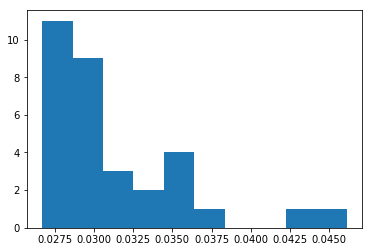

In [575]:
plt.hist(gan_rf.feature_importances_)

In [580]:
gan_rocs = []
gan_rels = []
for gan_config in range(0, 6):
    print(gan_config)
    gan_encoder_c = load_model("/scratch/dgagne/storm_gan_20170622/gan_encoder_00000{0:d}_epoch_0010.h5".format(gan_config))
    gan_encoded_data_c = gan_encoder_c.predict(scaled_storm_data)
    gan_logit_c = LogisticRegression(penalty="l2")
    gan_logit_c.fit(gan_encoded_data_c[train_indices], train_labels)
    gan_logit_preds_c = gan_logit_c.predict_proba(gan_encoded_data_c[test_indices])[:, 1]
    gan_rocs.append(DistributedROC(thresholds=thresholds))
    gan_rocs[-1].update(gan_logit_preds_c, test_labels)
    gan_rels.append(DistributedReliability(thresholds=thresholds))
    gan_rels[-1].update(gan_logit_preds_c, test_labels)
    print(gan_config, gan_rocs[-1].auc(), gan_rels[-1].brier_score())

0
0 0.700809896748 0.117428053625
1
1 0.710081881423 0.115780810795
2
2 0.71100853813 0.120186961855
3
3 0.706824307868 0.116852251884
4
4 0.711710993327 0.115223494363
5
5 0.704650066589 0.117800195689


In [582]:
gan_kmeans = KMeans()
gan_clusters = gan_kmeans.fit_predict(gan_encoded_data)

80779
0
20117
1
55808
2
90096
3
97478
4
50437
5
28946
6
2813
7


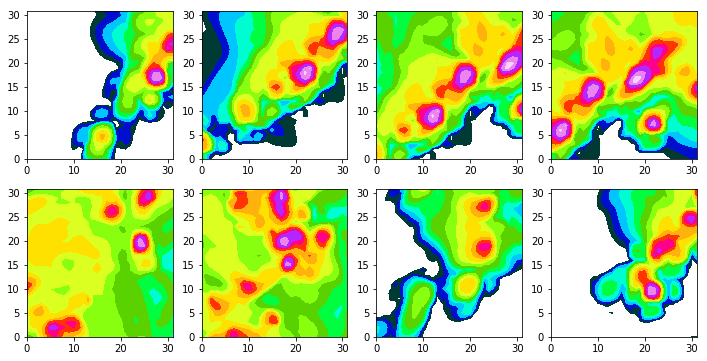

In [619]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axef = axes.ravel()
for c, cluster in enumerate(gan_kmeans.cluster_centers_):
    print(np.argmin(np.mean(np.abs(gan_encoded_data - cluster), axis=1)))
    print(c)
    axef[c].contourf(storm_data[c, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")

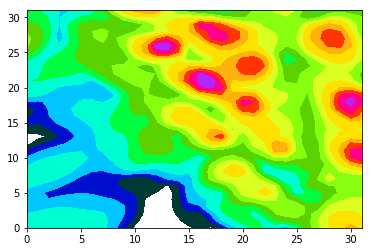

In [607]:
plt.contourf(storm_data[80779, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")

In [620]:
pickle.dump(gan_kmeans, open("/scratch/dgagne/hail_models/gan_kmeans.pkl", "wb"))

In [171]:
def hail_patch_multi_input_model(input_size=(32, 32, 1), num_vars=6, filter_width=5, min_data_width=8,
                    min_conv_filters=8, stride=2):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    image_inputs = [] 
    var_models = []
    for var in range(num_vars):
        curr_conv_filters = min_conv_filters
        model = None
        image_inputs.append(Input(shape=input_size, name="patch_input_{0:d}".format(var)))
        for c in range(num_layers):
            if c == 0:
                model = Conv2D(curr_conv_filters, filter_width,
                               strides=(stride, stride), padding="same",
                               kernel_initializer="lecun_normal",
                               kernel_regularizer=l2())(image_inputs[-1])
            else:
                model = Conv2D(curr_conv_filters, filter_width,
                               strides=(stride, stride), padding="same",
                               kernel_initializer="lecun_normal",
                               kernel_regularizer=l2())(model)
            model = Activation("selu")(model)
            #model = AlphaDropout(0.3)(model)
            #model = BatchNormalization()(model)
            curr_conv_filters *= 2
        var_models.append(model)
    model = None
    model = concatenate(var_models)
    model = Conv2D(256, filter_width, strides=(stride, stride), 
                   padding="same", kernel_initializer="lecun_normal", kernel_regularizer=l2())(model)
    model = Activation("selu")(model)
    model = Flatten()(model)
    model = Dense(1, kernel_regularizer=l2())(model)
    model = Activation("sigmoid")(model)
    return model, image_inputs

In [172]:
cnn_multi, cnn_multi_input = hail_patch_multi_input_model()
cnn_multi_model = Model(cnn_multi_input, cnn_multi)
cnn_multi_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9), loss="mse")
#hail_cnn_model.compile(optimizer="rmsprop", loss="mse")
cnn_multi_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
patch_input_0 (InputLayer)       (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
patch_input_1 (InputLayer)       (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
patch_input_2 (InputLayer)       (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
patch_input_3 (InputLayer)       (None, 32, 32, 1)     0                                            
___________________________________________________________________________________________

In [173]:
cnn_multi_model.fit([storm_norm_data[train_indices, :, :, x:x+1] for x in range(6)],
                              train_labels, batch_size=256,
                              validation_split=0.2, epochs=20, verbose=2)

Train on 65001 samples, validate on 16251 samples
Epoch 1/20
18s - loss: 0.5994 - val_loss: 0.2355
Epoch 2/20
17s - loss: 0.1552 - val_loss: 0.1850
Epoch 3/20
17s - loss: 0.1334 - val_loss: 0.1869
Epoch 4/20
17s - loss: 0.1283 - val_loss: 0.1781
Epoch 5/20
17s - loss: 0.1281 - val_loss: 0.1795
Epoch 6/20
17s - loss: 0.1272 - val_loss: 0.1883
Epoch 7/20
17s - loss: 0.1272 - val_loss: 0.1836
Epoch 8/20
17s - loss: 0.1280 - val_loss: 0.1870
Epoch 9/20
17s - loss: 0.1262 - val_loss: 0.1880
Epoch 10/20
17s - loss: 0.1270 - val_loss: 0.1811
Epoch 11/20
17s - loss: 0.1270 - val_loss: 0.1782
Epoch 12/20
17s - loss: 0.1258 - val_loss: 0.1848
Epoch 13/20
17s - loss: 0.1266 - val_loss: 0.1876
Epoch 14/20
17s - loss: 0.1270 - val_loss: 0.1899
Epoch 15/20
17s - loss: 0.1268 - val_loss: 0.1899
Epoch 16/20
17s - loss: 0.1266 - val_loss: 0.1831
Epoch 17/20
17s - loss: 0.1255 - val_loss: 0.1833
Epoch 18/20
17s - loss: 0.1275 - val_loss: 0.1888
Epoch 19/20
17s - loss: 0.1258 - val_loss: 0.1821
Epoch 20/

In [167]:
storm_norm_data[train_indices, :, :, 0:1].shape

(81252, 32, 32, 1)

In [178]:
cnn_multi_model_preds = cnn_multi_model.predict([storm_norm_data[test_indices, :, :, x:x+1] for x in range(6)])[:, 0]

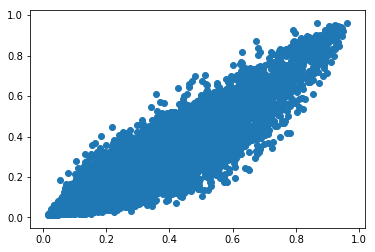

In [179]:
plt.scatter(cnn_preds, cnn_multi_model_preds)

In [177]:
cnn_multi_model_preds.shape

(31860, 1)